# NDVI

Calculating the Normalized Difference Vegetation Index (NDVI) is something I wanted to try.

I used [this](https://developers.planet.com/docs/planetschool/calculate-an-ndvi-in-python/) tutorial from Planet.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


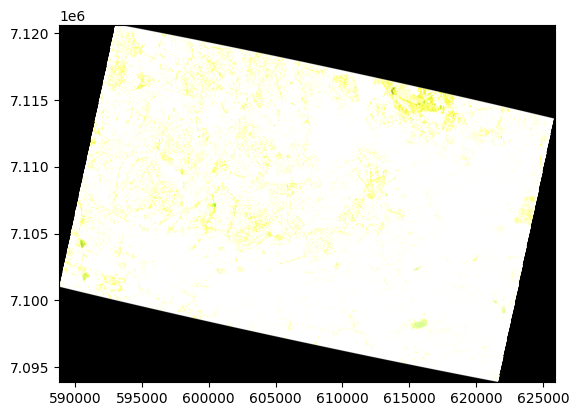

In [1]:
import rasterio
import numpy
from rasterio.plot import show
import matplotlib.pyplot as plt

image_file = '../data/images/20230318_075512_29_249d_3B_AnalyticMS_SR_8b.tif'
metadata_file = '../data/images/20230318_075512_29_249d_3B_AnalyticMS_8b_metadata.xml'

# Load red and NIR bands - note all PlanetScope 8-band images have band order:
# Band 1 = Coastal Blue
# Band 2 = Blue
# Band 3 = Green I
# Band 4 = Green
# Band 5 = Yellow
# Band 6 = Red
# Band 7 = Red Edge
# Band 8 = Near Infrared
with rasterio.open(image_file) as src:
    band_red = src.read(6)
    band_nir = src.read(8)
    show(src)


In [2]:
from xml.dom import minidom

xmldoc = minidom.parse(metadata_file)
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")


# XML parser refers to bands by numbers 1-8
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    i = int(bn)
    value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
    coeffs[i] = float(value)

In [3]:
# Multiply by corresponding coefficients
band_red_normalized = band_red * coeffs[6]
band_nir_normalized = band_nir * coeffs[8]

In [4]:
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

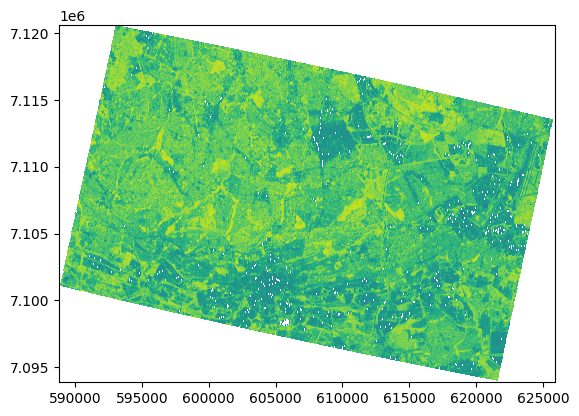

In [5]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))
with rasterio.open('ndvi.tif') as out:
    show(out)


In [6]:
plt.imsave("ndvi_cmap.png", ndvi, cmap=plt.cm.summer)